# Reconnaissance de caractères

*par Assane et Emma*

On vous propose dans ce projet de se pencher sur l'IA et de développer un réseau de neurone capable de reconnaitre des lettres.

On vous recommande d'éxécuter ce notebook sur Google Colab pour des raisons de rapidité (vous pourrez bénéficier du GPU de colab).

Si vous utilisez colab décommentez les lignes ci-dessous, sinon exécutez-les dans votre terminal.

In [ ]:
# !pip install tensorflow-hub
# !pip install tensorflow-datasets

In [3]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot

## Chargement des données
Pour notre projet nous avons décidé de nous appuyés sur des données déjà éprouvées c'est-à-dire les données de la base EMNIST. En l'occurence celle que nous utilisons contient au moins 100 000 données (et prend 44.14MiB).

Ensuite on ne charge pas les données n'importe comment : on les sépare d'entrée de jeu en différentes parties. Ainsi :
- train_data va contenir va représenter 60% des données d'entrainement
- validation_data va contenir 40% des données d'entrainement
- test_data représente la totalité des données de test

Les données d'entrainement seront exclusivement utilisées pour l'entrainement et celles de test uniquement pour les tests.

In [4]:
train_data, validation_data, test_data = tfds.load(
    name="emnist/letters", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/88800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/3.0.0.incompletePZOTCM/emnist-train.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/14800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/3.0.0.incompletePZOTCM/emnist-test.tfrecord*...:   0%|     …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/letters/3.0.0. Subsequent calls will reuse this data.


In [5]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Regardons quelques données pour voir à quoi elles ressemblent.
On constate que les lettres sont orientées dans des sens différents.

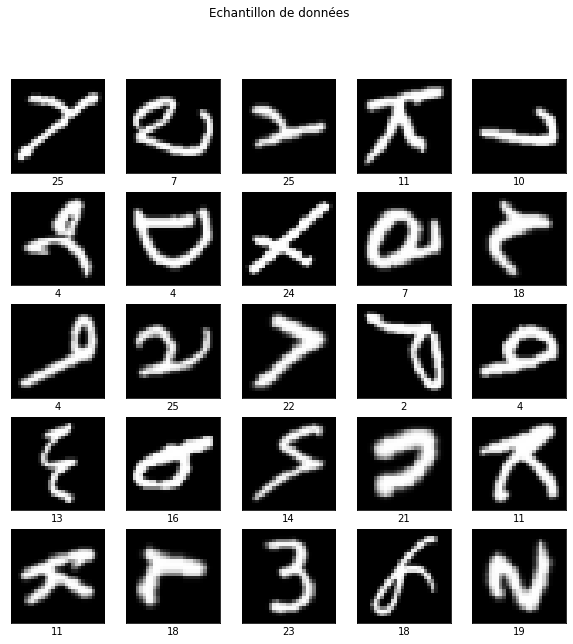

In [27]:
ds = train_data.take(25)
fig = matplotlib.pyplot.figure(figsize=(10,10))
fig.suptitle("Echantillon de données")
id = 22
i = 1
for image, label in tfds.as_numpy(ds):
  ax = fig.add_subplot(5, 5, i)
  i += 1
  ax.imshow(image[:, :, 0], cmap="gray")
  ax.set_xlabel(label)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.grid(False)

## Création du modèle

Dans cette étape on développe un modèle convolutif à 4 couches.
Le type d'algorithme qu'on utilise est la classification. Nos images sont catégorisées avec un label (ici un nombre entre 1 et 37) qui indique si l'image correspond à une lettre de l'alphabet ou à un chiffre.
Notre modèle a donc 37 neurones dans sa couches externes qui vont "contenir" son niveau de confiance en chaque catégorie. Mais nous reviendrons plus tard sur l'utilisation de cette couche...

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(62, activation='relu'),
    tf.keras.layers.Dense(37)
])

On indique au réseau comment on va l'évaluer.

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

On entraine le réseau sur les données d'entrainements mélangées dans des batch de 512 et on réalise 20 epochs.

Les epochs correspondent au nombre de fois ou le réseau voit passer toutes les données d'entrainement. A chaque époch le réseau va essayer de deviner les labels pour chaque image de chaque batch puis appliquer la fonction de coût et procéder à une descente de gradient pour se corriger. Après avoir fait passer tous les batch, le réseaux s'essait aux données de validation. 

Pour tous le process on a accès à la loss et à l'accurracy (pour les données de test); et la val_loss et val_accuracy (pour la validation).

On récupère l'historique de ces valeurs pour suivre l'efficacité de l'apprentissage du réseau et prendre des mesures en cas de sur interprétation (over-fitting) ou de sous interprétations (under-fitting) entre autre.

In [9]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/20
105/105 [==============================] - 9s 77ms/step - loss: 7.1706 - accuracy: 0.1315 - val_loss: 2.8504 - val_accuracy: 0.2396
Epoch 2/20
105/105 [==============================] - 3s 24ms/step - loss: 2.3825 - accuracy: 0.3635 - val_loss: 2.0083 - val_accuracy: 0.4691
Epoch 3/20
105/105 [==============================] - 2s 23ms/step - loss: 1.6588 - accuracy: 0.5386 - val_loss: 1.4599 - val_accuracy: 0.5923
Epoch 4/20
105/105 [==============================] - 3s 26ms/step - loss: 1.2262 - accuracy: 0.6480 - val_loss: 1.1974 - val_accuracy: 0.6601
Epoch 5/20
105/105 [==============================] - 3s 25ms/step - loss: 0.9833 - accuracy: 0.7148 - val_loss: 1.0137 - val_accuracy: 0.7171
Epoch 6/20
105/105 [==============================] - 3s 25ms/step - loss: 0.8235 - accuracy: 0.7586 - val_loss: 0.9322 - val_accuracy: 0.7355
Epoch 7/20
105/105 [==============================] - 3s 27ms/step - loss: 0.7172 - accuracy: 0.7870 - val_loss: 0.8408 - val_accuracy: 0.7659

On va donc regarder comment la loss et l'accuracy ont évolué.

In [10]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

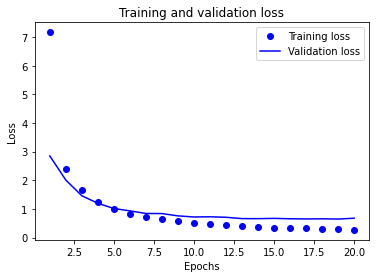

In [11]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

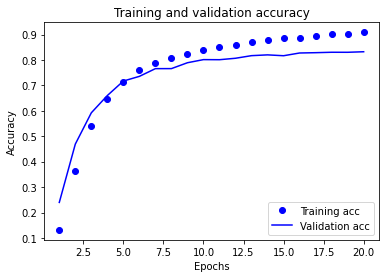

In [12]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

On a **un peu** d'over-fitting étant donné que la courbe de test de l'accuracy continue à croitre là ou la courbe de validation semble tendre vers une asymptote à 0.8.

## Test du modèle

In [13]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

29/29 - 1s - loss: 0.7391 - accuracy: 0.8148 - 1s/epoch - 46ms/step
loss: 0.739
accuracy: 0.815


La couche softmax permet de convertir les valeurs de la couche finale du réseau en probabilité et donc cette couche représente la confiance qu'à le modèle en l'appartenance du modèle à une catégorie donnée.

In [14]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [23]:
test, test_labels = next(iter(train_data.batch(10)))
test_labels = test_labels.numpy()

In [24]:
predictions = probability_model.predict(test, verbose=2)
predictions.shape

1/1 - 0s - 17ms/epoch - 17ms/step


(10, 37)

In [17]:
labels = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l",
"m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

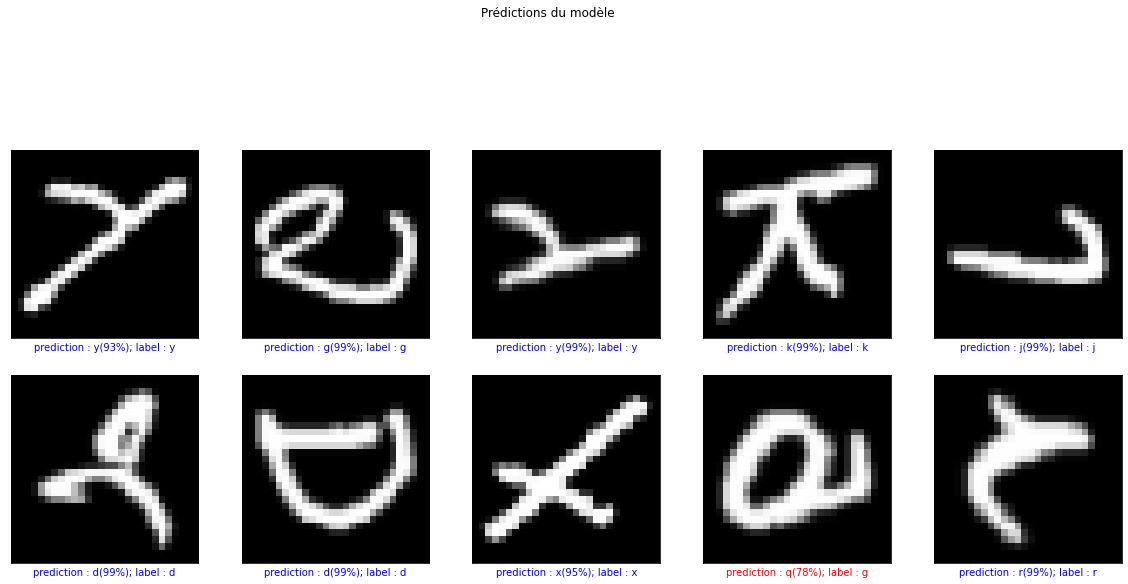

In [30]:
fig = matplotlib.pyplot.figure(figsize=(20, 20))
fig.suptitle("Prédictions du modèle")
for i in range(10):
    label = np.argmax(predictions[i])
    predicted = labels[label - 1]
    credance = int(predictions[i][label] * 100)
    realValue = labels[test_labels[i] - 1]
    if predicted == realValue :
      color = "blue"
    else :
      color = "red"
    ax = fig.add_subplot(5, 5, i + 1)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(test[i][:,:,0], cmap="gray")
    ax.set_xlabel("prediction : " + predicted + "(" + str(credance) +"%)" + "; label : " + realValue, color=color)